In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Extreme Gradient Boost

[XBOOST](https://xgboost.readthedocs.io/en/stable/)

In [35]:
try:
    import xgboost as xgb
except:
    %pip install xgboost
    import xgboost as xgb

In [36]:
file_enriched_features = "data/processed_data/hourly_solar_copernicus_enriched_data.feather"
file_weather_data = "data/processed_data/hourly_weather_data.feather"
file_solar_data="data/processed_data/daily_solar_data.feather"


In [37]:
import pandas as pd
df_enriched_features=pd.read_feather(file_enriched_features)
df_weather_data = pd.read_feather(file_weather_data)
df_solar_data = pd.read_feather(file_solar_data)

In [38]:
# Show the columns/features and data types for each dataset using pandas DataFrame
import seaborn as sns
sns.set_theme()
feature_columns = {
    "Enriched Features": df_enriched_features.columns,
    "Weather Data": df_weather_data.columns,
    "Solar Data": df_solar_data.columns,
}
for title, cols in feature_columns.items():
    print(f"\n{title} Columns and Data Types:")
    display(pd.DataFrame({"Columns": cols, "Data Types": eval(f"df_{title.lower().replace(' ', '_')}").dtypes}))


Enriched Features Columns and Data Types:


,Columns,Data Types
DateTime,DateTime,datetime64[ns]
# Observation period,# Observation period,object
TOA,TOA,float64
Clear sky GHI,Clear sky GHI,float64
Clear sky BHI,Clear sky BHI,float64
Clear sky DHI,Clear sky DHI,float64
Clear sky BNI,Clear sky BNI,float64
GHI,GHI,float64
BHI,BHI,float64
DHI,DHI,float64



Weather Data Columns and Data Types:


,Columns,Data Types
DateTime,DateTime,datetime64[ns]
Temperature(C),Temperature(C),Float64
Humidity(%),Humidity(%),Float64
Sunshine Duration,Sunshine Duration,Float64
Condition Code,Condition Code,Float64



Solar Data Columns and Data Types:


,Columns,Data Types
Date,Date,object
Number,Number,int64
Time,Time,object
Working State,Working State,object
PV(W),PV(W),float64
Battery(W),Battery(W),float64
Grid(W),Grid(W),float64
Load(W),Load(W),float64
SOC(%),SOC(%),float64
Total_Yield(kWh),Total_Yield(kWh),float64


Convert to hourly date time granularity

This is too see if I can get more accurate readings

In [39]:
# change all the 3  to an hourly aggregation using resample
print(df_enriched_features.columns.to_list())
df_solar_per_hour = df_solar_data[['PV(W)','DateTime']].resample('h', on='DateTime').agg('mean')
df_weather_per_hour = df_weather_data.resample('h', on='DateTime').agg({'Temperature(C)': 'mean',
                                                                     'Humidity(%)': 'mean',
                                                                     'Sunshine Duration': 'mean',
                                                                     'Condition Code': 'first',})
# 'DateTime', '# Observation period', 'TOA', 'Clear sky GHI', 'Clear sky BHI', 'Clear sky DHI', 'Clear sky BNI', 'GHI', 'BHI', 'DHI', 'BNI', 'Reliability,', 'Time', 'Date', 'POA_Pane_I(W/m^2)', 'POA_Pane_II(W/m^2)', 'POAC_Pane_I(W/m^2)', 'POAC_Pane_II(W/m^2)', 'Power_Pane_I(W)', 'Power_Pane_II(W)', 'Power_ClearSky_Pane_I(W)', 'Power_ClearSky_Pane_II(W)', 'Total_Power_Output(W)', 'Total_Power_ClearSky_Output(W)'
df_enriched_per_hour = df_enriched_features.resample('h', on='DateTime').agg({
    'TOA': 'mean',
    'Clear sky GHI': 'mean',
    'Clear sky BHI': 'mean',
    'Clear sky DHI': 'mean',
    'GHI': 'mean',
    'BHI': 'mean',
    'DHI': 'mean',
    'BNI': 'mean',
    'POA_Pane_I(W/m^2)': 'mean',
    'POA_Pane_II(W/m^2)': 'mean',
    'POAC_Pane_I(W/m^2)': 'mean',
    'POAC_Pane_II(W/m^2)': 'mean',
    'Power_Pane_I(W)': 'mean',
    'Power_Pane_II(W)': 'mean',
    'Power_ClearSky_Pane_I(W)': 'mean',
    'Power_ClearSky_Pane_II(W)': 'mean',
    'Total_Power_Output(W)': 'mean',
    'Total_Power_ClearSky_Output(W)': 'mean'
})

['DateTime', '# Observation period', 'TOA', 'Clear sky GHI', 'Clear sky BHI', 'Clear sky DHI', 'Clear sky BNI', 'GHI', 'BHI', 'DHI', 'BNI', 'Reliability,', 'Time', 'Date', 'POA_Pane_I(W/m^2)', 'POA_Pane_II(W/m^2)', 'POAC_Pane_I(W/m^2)', 'POAC_Pane_II(W/m^2)', 'Power_Pane_I(W)', 'Power_Pane_II(W)', 'Power_ClearSky_Pane_I(W)', 'Power_ClearSky_Pane_II(W)', 'Total_Power_Output(W)', 'Total_Power_ClearSky_Output(W)']


In [40]:
import numpy as np
# Merge the three dataframes on DateTime
df_merge_hourly = df_solar_per_hour.merge(df_weather_per_hour, on='DateTime').merge(df_enriched_per_hour, on='DateTime')
df_merge_hourly.reset_index(inplace=True)
# Add WeekOfYear
df_merge_hourly['WeekOfYear'] = df_merge_hourly['DateTime'].dt.isocalendar().week
df_merge_hourly['Month_Sin'] = np.sin(2 * np.pi * (df_merge_hourly['DateTime'].dt.month - 1) / 12)
df_merge_hourly['DayOfYear_Sin'] = np.sin(2 * np.pi * (df_merge_hourly['DateTime'].dt.dayofyear - 1) / 365)
df_merge_hourly['HourOfDay_Sin'] = np.sin(2 * np.pi * (df_merge_hourly['DateTime'].dt.hour) / 24)
# Count number Nan in target Y column
print("Number of NaN in PV(W):", df_merge_hourly['PV(W)'].isna().sum())
# Remove Nan in target Y column
df_merge_hourly = df_merge_hourly.dropna(subset=['PV(W)'])
# Count number of rows after removing NaN
print("Number of NaN  after removing in PV(W):", df_merge_hourly['PV(W)'].isna().sum())
print("Number of rows after removing NaN in PV(W):", len(df_merge_hourly))
print("Dataframe shape after removing NaN in PV(W):", df_merge_hourly.shape)

Number of NaN in PV(W): 413
Number of NaN  after removing in PV(W): 0
Number of rows after removing NaN in PV(W): 9976
Dataframe shape after removing NaN in PV(W): (9976, 28)


In [41]:
# display column list and data types and index
display(pd.DataFrame({"Columns": df_merge_hourly.columns, "Data Types": df_merge_hourly.dtypes}))


,Columns,Data Types
DateTime,DateTime,datetime64[ns]
PV(W),PV(W),float64
Temperature(C),Temperature(C),Float64
Humidity(%),Humidity(%),Float64
Sunshine Duration,Sunshine Duration,Float64
Condition Code,Condition Code,Float64
TOA,TOA,float64
Clear sky GHI,Clear sky GHI,float64
Clear sky BHI,Clear sky BHI,float64
Clear sky DHI,Clear sky DHI,float64


In [42]:
print("Columns:", df_merge_hourly.columns.tolist())#
#feature_cols = ['Temperature(C)', 'Humidity(%)', 'Condition Code', 'Month_Sin', 'DayOfYear_Sin', 'HourOfDay_Sin',
#                'Total_Power_ClearSky_Output(W)','Power_ClearSky_Pane_I(W)','Power_ClearSky_Pane_II(W)']
feature_cols = ['Temperature(C)', 'Humidity(%)', 'Condition Code', 'Month_Sin',  'HourOfDay_Sin', 
                'Total_Power_ClearSky_Output(W)','Sunshine Duration']
target_col = 'PV(W)'
print(f"\nTesting Random Forest Regressor with target: {target_col} and features: {feature_cols}")
# first we filter  out where the output is less than threshold - to avoid night time data , this is based on clearsky GHI
df_daytime = df_merge_hourly['Clear sky GHI'] > 10
# now split into test and training based test and train data sets are every other week
df_daytime_train = df_merge_hourly[(df_merge_hourly['WeekOfYear'] % 2 == 0) & (df_daytime)]
df_daytime_test = df_merge_hourly[(df_merge_hourly['WeekOfYear'] % 2 == 1) & (df_daytime)]
print("Training DataFrame shape:", df_daytime_train.shape)
print("Testing DataFrame shape:", df_daytime_test.shape)
# Create x and y for training and testing
X_train = df_daytime_train[feature_cols]
y_train = df_daytime_train[target_col]
X_test = df_daytime_test[feature_cols]
y_test = df_daytime_test[target_col]


Columns: ['DateTime', 'PV(W)', 'Temperature(C)', 'Humidity(%)', 'Sunshine Duration', 'Condition Code', 'TOA', 'Clear sky GHI', 'Clear sky BHI', 'Clear sky DHI', 'GHI', 'BHI', 'DHI', 'BNI', 'POA_Pane_I(W/m^2)', 'POA_Pane_II(W/m^2)', 'POAC_Pane_I(W/m^2)', 'POAC_Pane_II(W/m^2)', 'Power_Pane_I(W)', 'Power_Pane_II(W)', 'Power_ClearSky_Pane_I(W)', 'Power_ClearSky_Pane_II(W)', 'Total_Power_Output(W)', 'Total_Power_ClearSky_Output(W)', 'WeekOfYear', 'Month_Sin', 'DayOfYear_Sin', 'HourOfDay_Sin']

Testing Random Forest Regressor with target: PV(W) and features: ['Temperature(C)', 'Humidity(%)', 'Condition Code', 'Month_Sin', 'HourOfDay_Sin', 'Total_Power_ClearSky_Output(W)', 'Sunshine Duration']
Training DataFrame shape: (2176, 28)
Testing DataFrame shape: (2187, 28)


In [43]:
# 3. Initialize XGBoost Regressor
# n_estimators: Number of boosting rounds (trees)
# learning_rate: Step size shrinkage used to prevent overfitting
# max_depth: Maximum depth of a tree
# After prompting with gemini pro - and asking why the parameters , n_estismators=100, learning_rate=0.1, max_depth=10 , random_state=42 were chosen
# is underperformaing compared to random forest
# The recommendations are as follows
# max_depth=3-6 because can cause a depth trap which results in overfitting and poor generalization to unseen data. which i am seeing 
# from training 95% and test 51% , this resulted model going training 59 , and test 54%
# learning_rate=0.1 and n_estimators-100 - results in early stopping , and incomplete learning if set too low or too high respectively
# set too n_estimateors between 500-1000 for better learning 
# accurace now 69 and training 51
# 1000 74 and 50
# missing regularization subsample=0.8 and colsample_bytree=0.8.
xg_reg = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=1000,           # Give it room to learn
    learning_rate=0.05,          # Slow down the learning to be more precise
    max_depth=5,                 # Shallower trees prevent overfitting
    subsample=0.8,               # Randomly sample 80% of rows per tree
    colsample_bytree=0.8,        # Randomly sample 80% of features per tree
    random_state=42,
    n_jobs=-1                    # Use all CPU cores
)

# 4. Fit the model
print("Training XGBoost model...")
xg_reg.fit(X_train, y_train)
# save model
xg_reg.save_model("solar_xboost.json")
print("Training complete.")

y_test_pred = xg_reg.predict(X_test)
y_train_pred = xg_reg.predict(X_train)

Training XGBoost model...
Training complete.


In [44]:
# 5. Make Predictions
from sklearn.metrics import mean_absolute_percentage_error
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error



# 6. Evaluate Performance
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_mae = mean_absolute_error(y_test, y_test_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
mape_test = mean_absolute_percentage_error(y_test,y_test_pred)
mape_train = mean_absolute_percentage_error(y_train,y_train_pred)
# normalized rmse  using 8400 
test_n_rmse = test_rmse / 8400
train_n_rmse = train_rmse / 8400
# normalized mae
test_n_mae = test_mae / 8400
train_n_mae = train_mae / 8400
# R^2
test_r2 = xg_reg.score(X_test, y_test)
train_r2 = xg_reg.score(X_train, y_train)
# Accuruacy value 
test_accuracy = 1 - mean_absolute_percentage_error(y_test, y_test_pred)
train_accuracy = 1 - mean_absolute_percentage_error(y_train, y_train_pred)

# convert to  normalized value percentages
perc_normalized_rmse_test = test_n_rmse * 100
perc_normalized_rmse_train = train_n_rmse * 100
perc_normalized_mae_test = test_n_mae * 100
perc_normalized_mae_train = train_n_mae * 100
accuracy_percent_test = test_accuracy * 100
accuracy_percent_train = train_accuracy * 100
print(f"Root Mean Squared Error (RMSE): {test_rmse:.2f} W")
print(f"Normalized RMSE: {test_n_rmse:.4f}")
print(f"Mean Absolute Error (MAE): {test_mae:.2f} W")
print(f"Normalized MAE: {test_n_mae:.4f}")
print(f"Mean Absolute Percentage Error (MAPE) {mape_test:.2f} ")
print(f"R^2: {test_r2:.4f}")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"Normalized RMSE: {perc_normalized_rmse_test:.2f} %")
print(f"Normalized MAE: {perc_normalized_mae_test:.2f} %")
print(f"Accuracy: {accuracy_percent_test:.2f} %")

mk_string = """| Metric       | Training Set        | Testing Set         |
|--------------|---------------------|---------------------|
| RMSE         | {:.2f}              | {:.2f}              |
| MAE          | {:.2f}              | {:.2f}              |
| R2           | {:.4f}              | {:.4f}              |
| N-RMSE (%)   | {:.4f}              | {:.4f}              |
| N-MAE (%)    | {:.4f}              | {:.4f}              |
| Accuracy (%) | {:.4f}              | {:.4f}              |""".format(
    train_rmse, test_rmse,
    train_mae, test_mae,
    train_r2, test_r2,
    train_n_rmse*100, test_n_rmse*100,
    train_n_mae*100, test_n_mae*100,
    train_accuracy*100, test_accuracy*100
)
from IPython.display import display, Markdown
display(Markdown(mk_string))
# Workk out MAPE


Root Mean Squared Error (RMSE): 667.45 W
Normalized RMSE: 0.0795
Mean Absolute Error (MAE): 477.86 W
Normalized MAE: 0.0569
Mean Absolute Percentage Error (MAPE) 0.47 
R^2: 0.7688
Accuracy: 0.5285
Normalized RMSE: 7.95 %
Normalized MAE: 5.69 %
Accuracy: 52.85 %


| Metric       | Training Set        | Testing Set         |
|--------------|---------------------|---------------------|
| RMSE         | 123.63              | 667.45              |
| MAE          | 91.80              | 477.86              |
| R2           | 0.9925              | 0.7688              |
| N-RMSE (%)   | 1.4718              | 7.9458              |
| N-MAE (%)    | 1.0928              | 5.6888              |
| Accuracy (%) | 87.1619              | 52.8535              |

<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

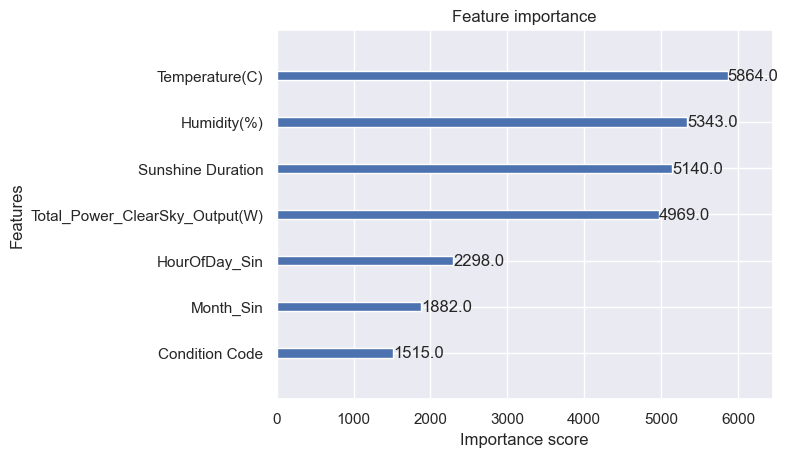

In [45]:
xgb.plot_importance(xg_reg)

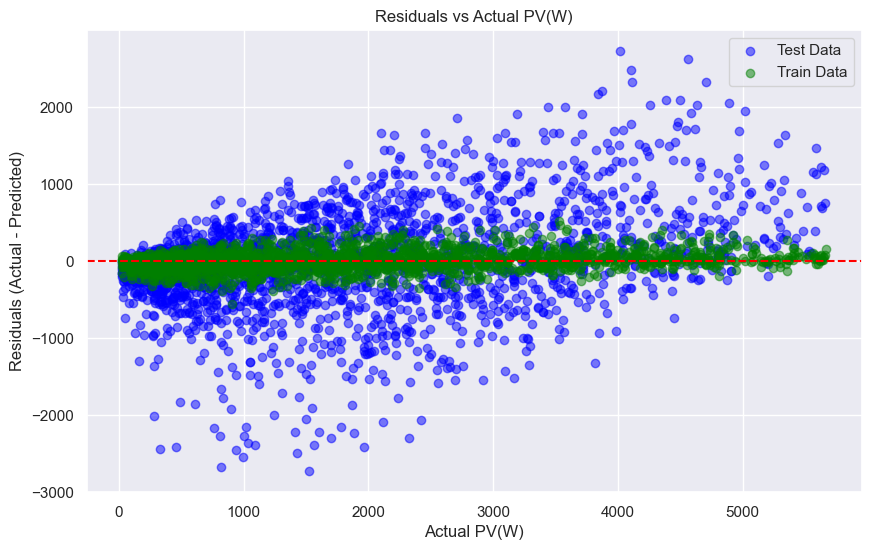

In [46]:
# plot residuals
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.scatter(y_test, y_test - y_test_pred, color='blue', label='Test Data', alpha=0.5)
plt.scatter(y_train, y_train - y_train_pred, color='green', label='Train Data', alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Residuals vs Actual PV(W)')
plt.xlabel('Actual PV(W)')
plt.ylabel('Residuals (Actual - Predicted)')
plt.legend()
plt.show()

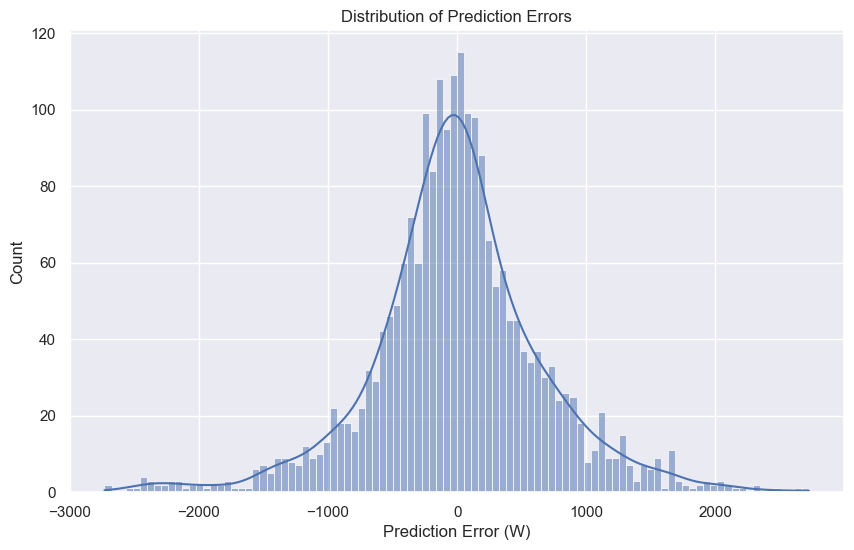

In [47]:
# pot error distribution
errors = y_test - y_test_pred
plt.figure(figsize=(10,6))
sns.histplot(errors, bins=100, kde=True)
plt.title('Distribution of Prediction Errors')
plt.xlabel('Prediction Error (W)')
plt.show()

<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

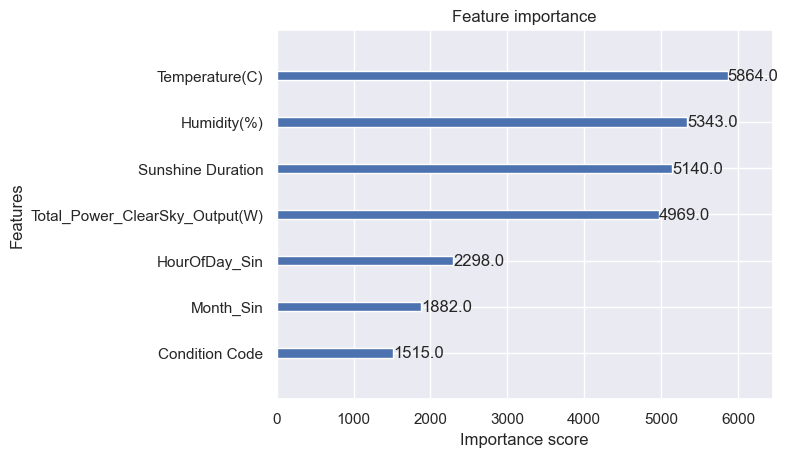

In [48]:
xgb.plot_importance(xg_reg)

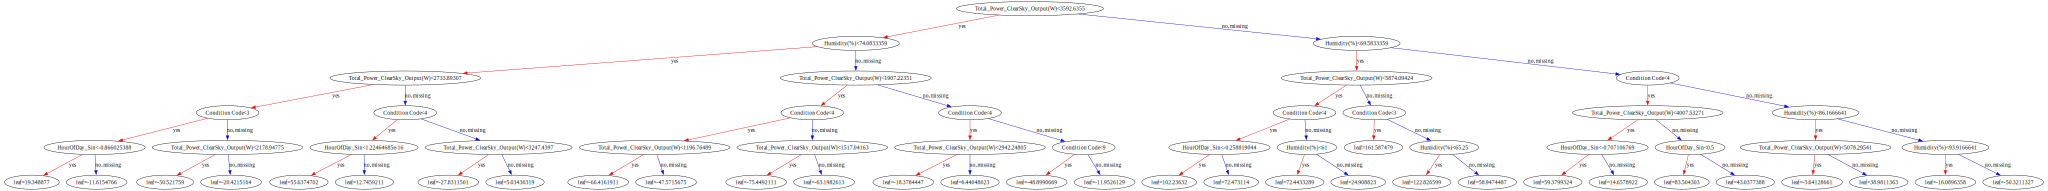

In [49]:
try:
    import graphviz
except: 
    %pip install graphviz
    import graphviz

#xgb.plot_tree(xg_reg)
xgb.to_graphviz(xg_reg)

NameError: name 'y_pred' is not defined

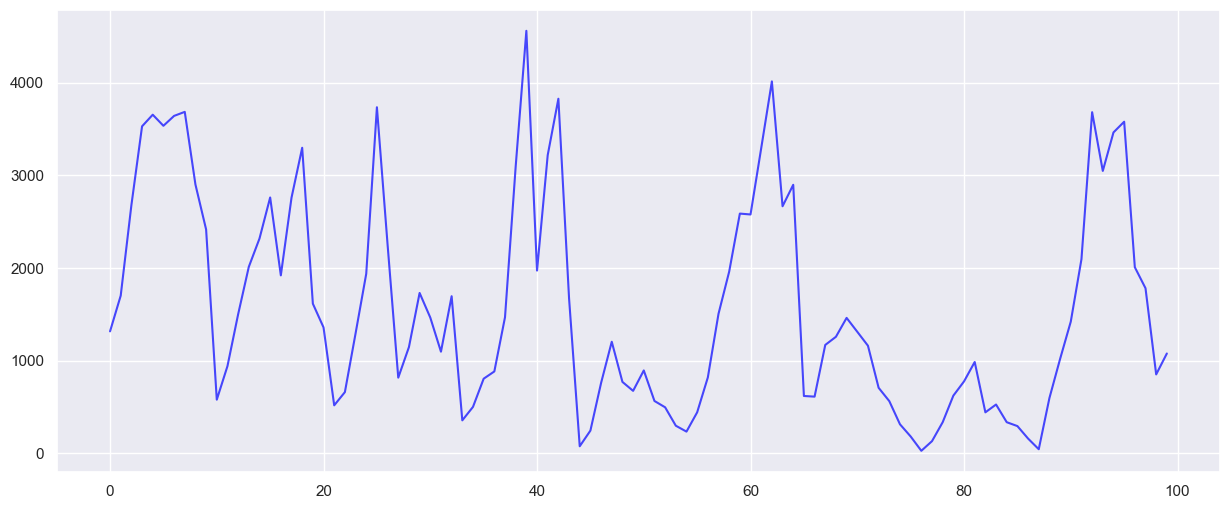

In [50]:


# 7. Visualize Actual vs Predicted (First 100 test points for clarity)
plt.figure(figsize=(15, 6))
plt.plot(y_test.values[:100], label='Actual PV(W)', color='blue', alpha=0.7)
plt.plot(y_pred[:100], label='Predicted PV(W)', color='red', linestyle='--', alpha=0.7)
plt.title('XGBoost: Actual vs Predicted Solar Output (First 100 Test Samples)')
plt.xlabel('Sample Index')
plt.ylabel('Power (W)')
plt.legend()
plt.show()

# 8. Feature Importance Plot
plt.figure(figsize=(10, 6))
xgb.plot_importance(xg_reg, max_num_features=10)
plt.title('XGBoost Feature Importance')
plt.show()

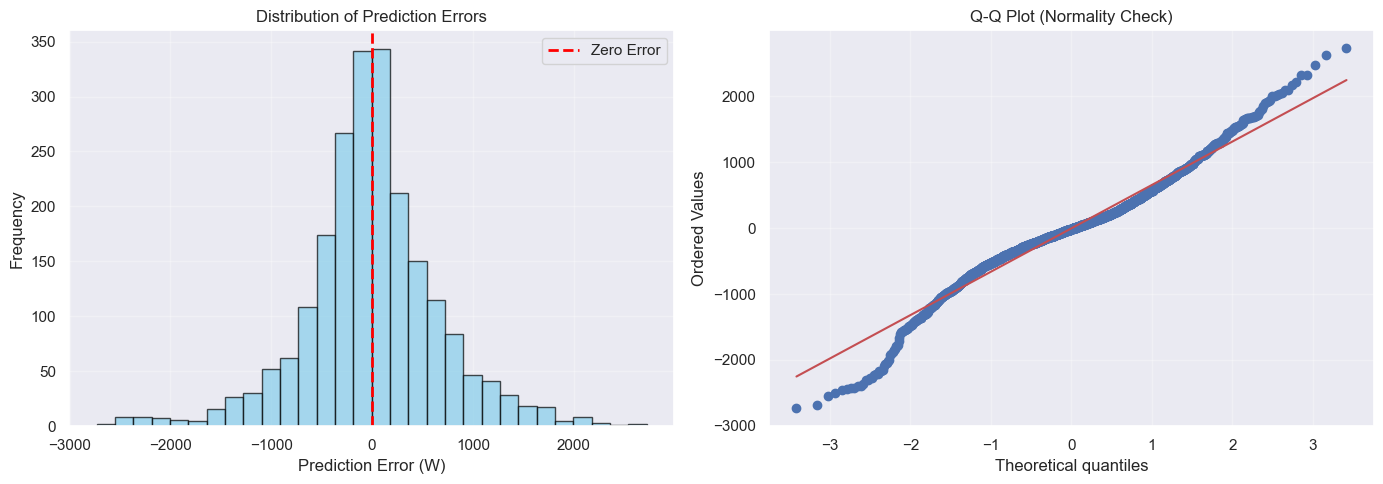

Error Mean: -3.22 W
Error Std Dev: 667.44 W
Error Min: -2730.83 W
Error Max: 2724.47 W


In [ ]:
# plot error distribution
# plot error distribution
errors = y_test.values - y_test_pred

plt.figure(figsize=(14, 5))

# Histogram of errors
plt.subplot(1, 2, 1)
plt.hist(errors, bins=30, edgecolor='black', alpha=0.7, color='skyblue')
plt.xlabel('Prediction Error (W)')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Errors')
plt.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero Error')
plt.legend()
plt.grid(alpha=0.3)

# Q-Q plot for normality check
plt.subplot(1, 2, 2)
from scipy import stats
stats.probplot(errors, dist="norm", plot=plt)
plt.title('Q-Q Plot (Normality Check)')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Print error statistics
print(f"Error Mean: {errors.mean():.2f} W")
print(f"Error Std Dev: {errors.std():.2f} W")
print(f"Error Min: {errors.min():.2f} W")
print(f"Error Max: {errors.max():.2f} W")